<center> <h1> Deep Reinforcement Learning </h1> </center>

In this homework, we will create a chess-playing agent.

More specifically, we will:
1. Implement a deep neural network to map board states to actions (i.e. policy).
2. Make our agent play a great amount of simplified chess games against an opponent (weak stockfish chess engine).
3. Assign rewards to game outcomes ( +1 for a win, -1 for a lost game, 0 for a draw).
3. Using the rewards, we will estimate gradients to improve our policy function (deep neural network).
4. Use our learnt policy to consistently defeat our opponent.

<center> <h2> Setup </h2> </center>

#### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your colaboratory notebook with us so
that we can grade it. We will also use colaboratory for the homework #4 so this
homework will prepare you for it.

#### Python-chess library

In order to avoid implementing the rules of the chess and visualization features we will use
a ```python-chess``` library. It is already a part of any google colaboratory environment so you do not
need to do any additional steps. We recommend you to go through a small tutorial on ```python-chess``` library:
https://jupyter.brynmawr.edu/services/public/dblank/CS371%20Cognitive%20Science/2016-Fall/Programming%20a%20Chess%20Player.ipynb

#### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write/change/uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. Paste the link into your submission pdf file so that we can view it and grade.

#### Additional

Follow the steps below to get a latest python chess library, download a stockfish chess playing engine to model our opponent and install some visualization libraries to track our progress during training. Since we are using google colab be aware that it might restart the environment in 24h and you will have to run all the steps below once again.



In [ ]:
pip install python-chess~=0.26

In [ ]:
pip install livelossplot==0.3.4

In [ ]:
!wget https://www.dropbox.com/sh/75gzfgu7qo94pvh/AACk_w5M94GTwwhSItCqsemoa/Stockfish%205/stockfish-5-linux.zip

In [ ]:
!unzip stockfish-5-linux.zip

In [ ]:
!chmod +x stockfish-5-linux/Linux/stockfish_14053109_x64

<center> <h2> Problem statement </h2> </center>

In this work we will try to find the best move given current position of figures on the board, 
assuming that we play against a known player (weak stockfish player).

(It is useful to know the rules of chess before you start:
https://en.wikipedia.org/wiki/Rules_of_chess)


To reduce the training time, we will make a couple of simplifications:

1. We will always play with white figures.
2. We will use a predefined simple starting position for the board.

Below you can see our starting position: each opponent has 4 queens at the beginning.


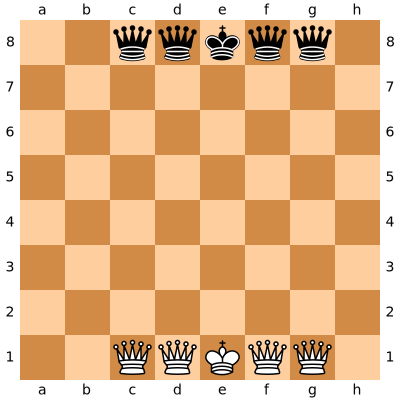

In [ ]:
import chess
import chess.pgn
import chess.engine

import torch
import numpy as np


board = chess.Board(fen='2qqkqq1/8/8/8/8/8/8/2QQKQQ1 w - -')
board

<center> <h2> Board matrix representation </h2> </center>

In order to be able to use neural network as a model for our policy we will have to convert the board into a matrix representation. We will end up with matrix of size $8 \times 8$ where digit at every position will represent the presence of a figure or its absence. Here we use PyTorch framework and you might find [this tutorial useful ]( https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html).
Below we provide the code and show an example of matrix representation of the board position.




In [ ]:

# A function that converts the board into matrix representation
def board_to_tensor(board):
    
    # Python chess uses flattened representation of the board
    x = torch.zeros(64, dtype=torch.float)

    for pos in range(64):

        piece = board.piece_type_at(pos)

        if piece:

            color = int(bool(board.occupied_co[chess.BLACK] & chess.BB_SQUARES[pos]))

            col = int(pos % 8)
            row = int(pos / 8)

            x[row * 8 + col] = -piece if color else piece

    x = x.reshape(8, 8)
        
    return x


board_tensor = board_to_tensor(board)

# For visualization we need to flip it to align with
# the board picture. Positive numbers represent white figure, negative numbers
# represent black figures. The maginitude of the number represents the figure type.
np.flipud( board_tensor.numpy() )

array([[ 0.,  0., -5., -5., -6., -5., -5.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  5.,  5.,  6.,  5.,  5.,  0.]], dtype=float32)

<center> <h2> Action matrix representation </h2> </center>

On the other hand, the output of the network will be another tensor that we will have to use to decide which action to take. Our output tensor will be of the size $64 \times 64$. The element in this tensor will represent an action of picking up a piece from a postion any position at the board ($64$ possible positions) and puting it on any position at the board (another  $64$ possible positions). We also make a small simplification here assuming that when a figure is promoted, it is always promoted to a queen. Not all actions will be legal given a position of the board but during training we will only take legal ones into consideration.

Below you can see a set of function that implement the aforementioned representation. More specifically, we implement the function that finds an index of the element that represnets a move in the $64 \times 64$ matrix.





In [ ]:

def move_to_index_tensor(move):
  
    index_tensor = torch.LongTensor([0])

    square_to_pick_figure = move.from_square

    # Can decode exact position this way:
    #square_to_pick_figure_row = int(square_to_pick_figure / 8)
    #square_to_pick_figure_col = int(square_to_pick_figure % 8)

    square_to_put_figure = move.to_square

    # Can decode exact position this way:
    #square_to_put_figure_row = int(square_to_put_figure / 8)
    #square_to_put_figure_col = int(square_to_put_figure % 8)

    index = square_to_pick_figure * 64 + square_to_put_figure

    index_tensor = torch.LongTensor([index])

    return index_tensor

  
def filter_legal_moves(legal_moves):
  
    filtered_legal_moves = []

    for legal_move in legal_moves:

        # Here we check if it is a promotion and
        # only leave promotion if it is a promotion to a queen
        if legal_move.promotion is not None:

            if legal_move.promotion == 5:

                filtered_legal_moves.append(legal_move)

            continue

        filtered_legal_moves.append(legal_move)

    return filtered_legal_moves


def legal_moves_to_index_tensors(legal_moves):
  
    legal_moves_index_tensors = [move_to_index_tensor(legal_move) for legal_move in legal_moves]

    return legal_moves_index_tensors


In [ ]:
legal_moves = list(board.legal_moves)

index_tensors = legal_moves_to_index_tensors(legal_moves)

print(legal_moves[1])

# Coordinates of the board with the origin in the left bottom corner

# Position of the square to pick the figure from
print(index_tensors[1] / 64 / 8)
print(index_tensors[1] / 64 % 8)

# Position of the square to puth the figure to
print(index_tensors[1] % 64 / 8)
print(index_tensors[1] % 64 % 8)


g1g7
tensor([0])
tensor([6])
tensor([6])
tensor([6])


<center> <h2> Neural Network </h2> </center>

Once we have the input and output tensors and their sizes, we can define a neural network
that will predict the next move given current board. Here we will ask you to fill in missing part of our network definition. Have a look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)  to get a better understanding of pytorch network API .




In [ ]:
import torch.nn as nn
from torch.nn import functional as F

# The input to the network is a tensor of size 8*8 (it is flattened)
# The output of the network is 64*64 (it is flattened too)
# The size of the hidden layer should be 512

class Network(nn.Module):
  
    def __init__(self, number_of_actions=64*64):

        super(Network, self).__init__()
        
        # Fill up the values below in nn.Linear()
        self.layer1 = nn.Linear(64, 512)
        self.layer2 = nn.Linear(512, number_of_actions)
        
        # Initialization of weights in the layers
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
        
                
    def forward(self, x):

        x =  F.relu( self.layer1(x) )
        
        # Logits will be fed into softmax layer to get probabilities
        # for each move later.
        logits =  self.layer2(x)
        
        return logits


In [ ]:

# Check the correctness of your code below
net = Network(number_of_actions=64*64)

dummy_input = torch.zeros(1, 64)

output = net(dummy_input)
print(output.shape)

torch.Size([1, 4096])


<center> <h2> Rewards and reward discounting  </h2> </center>

Now, let us assume that we used our network as is during one game and we got a reward at the end of the game. Most probably it will be $-1$ since our network does not know anything yet.

But we ran our network multiple times with different board position before reaching the terminal state that gave us the reward. Now we should give reward to our every action during this game. We can either judge the goodness of every individual action based on whether or not we won the game at the end. Also it is a good practice to apply reward discounting. The idea of reward discounting is that we judge the "goodness" of an action by the sum of  exponentially discounted rewards obatined afterwards. For example, the sequence of actions right before we recieved the final reward (won the chess game) will get bigger scores. Also, in case of defeat, in the game of chess if you were checkmated, it is probably because of the last 10 moves or so -- therefore these moves will receive negative scores with bigger magnitude.
Here is a formal definition of the reward discounting (discounted "reward to go").

$$R_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$$

Imagine that after the game, our $R_N$ (reward of the last action) is known to be either $-1$ $+1$ or $0$ and $\gamma$ is equal to $0.99$ in our example.
Below we will ask you to implement it.

In [ ]:

# Collected moves is an array that contains
# pairs of taken action and reward. You will have to adjust the reward
# only
# It can be this for example: [[None,0], [None,0], [None,0], [None,0], [None,-1]]if we lost
# in four moves. None is placed for simplicity

def discount_rewards(collected_moves, gamma=0.99):
    
    running_reward = 0.0

    for index, collected_move in enumerate(reversed(collected_moves)):
        
        reward = collected_move[1]
        running_reward = running_reward * gamma + reward
        collected_move[1] = running_reward
    

In [ ]:
# Compare to our output
dummy_input = [[None,0], [None,0], [None,0], [None,0], [None,1]]
discount_rewards(dummy_input)
dummy_input

[[None, 0.96059601],
 [None, 0.9702989999999999],
 [None, 0.9801],
 [None, 0.99],
 [None, 1.0]]

It is also a good practice to normalize the rewards to make the training more stable.
Below we will ask you to subtract the mean of the rewards and divide that by its standart deviation.

In [ ]:
def normalize_rewards(collected_moves):
    
    normalized_rewards = np.asarray(list(map(lambda x: x[1], collected_moves)), dtype=np.float)
    
    normalized_rewards -= np.mean(normalized_rewards)
    normalized_rewards /= np.std(normalized_rewards)
    
    
    for index, collected_move in enumerate(collected_moves):
        
        collected_move[1] = normalized_rewards[index]


In [ ]:
# Compare to our output
normalize_rewards(dummy_input)
dummy_input

[[None, -1.407096445964472],
 [None, -0.710618951904956],
 [None, -0.007106331642812231],
 [None, 0.7035124767027847],
 [None, 1.4213092528094475]]

<center> <h2> Policy Gradients  </h2> </center>

After we run each game with our opponent we recieve reward and we know which moves we made during that game. Using this data we can estimate gradients for parameters of our network. Having the gradients, we can update our weights after we played a couple of games and slightly improve our policy network. 

More precicely, it can be formulated as:

$$\nabla_{\theta}J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T}\nabla_{\theta} \log \pi_{\theta}(a_{i,t}|s_{i,t}) \left( \sum_{t'=t}^{T} \gamma^{t' - t} r(a_{i,t'},s_{i,t'})\right)  \\ = \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T}\nabla_{\theta} \log \pi_{\theta}(a_{i,t}|s_{i,t}) R_t$$



Where $J$ is a function of expected reward that we are trying to increase. $\pi_{\theta}$ is our policy function which is modeled by neural network. $a_{i,t},s_{i,t}$ is an action taken in a game $i$ at time step $t$ given board position $ s_{i,t}$ at that time. $r(a_{i,t},s_{i,t})$ is a reward of that action. $R_t$ is a discounted "reward to go" defined previously. it should be emphasized that during training we sample actions from our policy function $\pi_{\theta}$ which allows to explore new different actions. For more information about the theory of this method we refer reader to at [these slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-5.pdf). And for more practical example and intuition behind this method to  [this blog post](http://karpathy.github.io/2016/05/31/rl/).

Below we provide the rest of the code for the aforementioned method.
You can see the progress in real time during optimization. It is enough to get your agent to be equal or better to your opponent, after that you can stop the optimization. After that you can make it play against stockfish. It has to be mentioned that stockfish engine is random and sometimes makes different move given the same board position. It means that you can try multiple games and they all be different.

In [ ]:
from torch.distributions import Categorical
import random


def get_games_data(policy_net, episodes=100):
  
    all_moves = []
    
    lost_count = 0
    draw_count = 0
    win_count = 0
    
    
    game_lengths_sum = 0.0
    
    for episode in range(episodes):
        
        engine = chess.engine.SimpleEngine.popen_uci("stockfish-5-linux/Linux/stockfish_14053109_x64")
        engine.configure({"Clear Hash": True})
        
        board = chess.Board(fen='2qqkqq1/8/8/8/8/8/8/2QQKQQ1 w - -')
        collected_moves = []
        board_sign = 1
        move_counter = 0.0
        
        while not board.is_game_over(claim_draw=True):

            if board_sign == 1:

                # Converting the board to a tensor representation
                board_tensor = board_to_tensor(board).reshape(-1)

                board_tensor_batched = board_tensor.unsqueeze(0)

                # Getting the logits output
                logits = policy_net(board_tensor_batched)

                # Now we need to select only legal moves
                # in python-chess format
                current_legal_moves = filter_legal_moves(list(board.legal_moves))


                legal_moves_index_tensors = legal_moves_to_index_tensors(current_legal_moves)


                legal_moves_logits = logits[:, legal_moves_index_tensors]

                # Here we sample the action using valid logits
                categorical_sampler = Categorical(logits=(legal_moves_logits))

                sampled_action = categorical_sampler.sample()

                sampled_action_move_object = current_legal_moves[sampled_action]

                log_prob = categorical_sampler.log_prob(sampled_action)

                board.push(sampled_action_move_object)

                # Board tensor, legal_moves_indexes, sampled_action_label, reward (0 if not known yet)
                collected_moves.append([log_prob, 0.0])

            else:
                
                result = engine.play(board, chess.engine.Limit(depth=1, nodes=3))
                board.push(result.move)


            board_sign = board_sign * -1
            move_counter = move_counter + 1

        
        if board.is_checkmate():
          
          if board_sign == 1:
            
            reward = -1.0
            lost_count = lost_count + 1
          else:
            
            reward = 1.0
            win_count = win_count + 1
        
        if not board.is_checkmate():
          
          reward = 0.1
          draw_count = draw_count + 1

        game_lengths_sum = game_lengths_sum + move_counter
        
        collected_moves[-1][1] = reward
        
        discount_rewards(collected_moves)
        
        all_moves.extend(collected_moves)
        
        engine.quit()
    
    
    average_game_length = game_lengths_sum / episodes
    
    stats = { "lost": lost_count,
              "draw": draw_count,
              "win": win_count,
              "average game length": average_game_length
            }
    
    normalize_rewards(all_moves)
    
    
    return all_moves, stats

In [ ]:
import torch
import torch.optim as optim

net = Network(number_of_actions=64*64)

optimizer = optim.Adam(net.parameters(), lr=0.01)

In [ ]:
from livelossplot import PlotLosses

liveloss = PlotLosses()

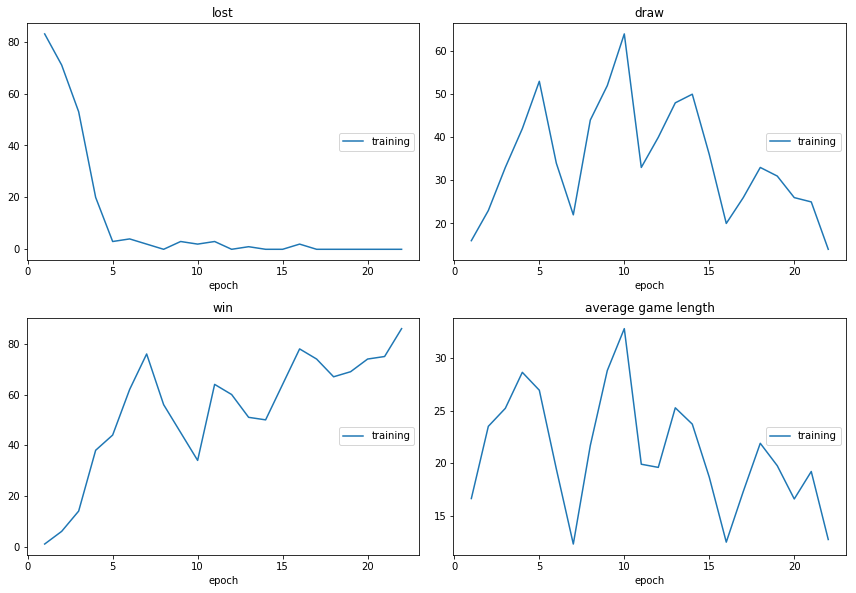

lost:
training   (min:    0.000, max:   83.000, cur:    0.000)

draw:
training   (min:   14.000, max:   64.000, cur:   14.000)

win:
training   (min:    1.000, max:   86.000, cur:   86.000)

average game length:
training   (min:   12.320, max:   32.780, cur:   12.750)


In [ ]:

# Stop it when you are happy with the displayed results
# Each iteration takes a while, be patient

while True:
    
    collected_moves, stats = get_games_data(policy_net=net, episodes=100)
    
    logs = [collected_move[0] for collected_move in collected_moves]
    rewards = [collected_move[1] for collected_move in collected_moves]
    
    logs_tensor = torch.cat(logs)
    rewards_tensor = torch.FloatTensor(rewards)
    
    optimizer.zero_grad()

    policy_loss = -logs_tensor * rewards_tensor

    policy_loss = policy_loss.sum()
    
    policy_loss.backward()
    
    optimizer.step()
    
    liveloss.update(stats)
    liveloss.draw()
    

Below you can test your agent against the stockfish play.

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("stockfish-5-linux/Linux/stockfish_14053109_x64")
engine.configure({"Clear Hash": True})
moves = []

board_sign = 1

net.eval()

board = chess.Board(fen='2qqkqq1/8/8/8/8/8/8/2QQKQQ1 w - -')

while not board.is_game_over(claim_draw=True):
    
    if board_sign == 1:

        # Converting the board to a tensor representation
        board_tensor = board_to_tensor(board).reshape(-1)


        board_tensor_batched = board_tensor.unsqueeze(0)

        # Getting the logits output
        logits = net(board_tensor_batched)

        current_legal_moves = filter_legal_moves(list(board.legal_moves))


        legal_moves_index_tensors = legal_moves_to_index_tensors(current_legal_moves)


        legal_moves_logits = logits[:, legal_moves_index_tensors]

        _, prediction = legal_moves_logits.max(1)
        sampled_action_move_object = current_legal_moves[prediction]
        board.push(sampled_action_move_object)
    else:
        
        result = engine.play(board, chess.engine.Limit(depth=1, nodes=3))
        board.push(result.move)

    moves.append(board.copy())
    board_sign = board_sign * -1

engine.quit()

In [ ]:
# See the game

from time import sleep
from IPython.display import display, HTML, clear_output

def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"


for move in moves:
  
  html = display_board(move, True)
  clear_output(wait=True)
  display(HTML(html))
  sleep(4.0)